In [1]:
import csv
import numpy as np
import scipy as sp
import astropy as ap
import matplotlib.pyplot as plt
import pandas as pd
from scipy import integrate 
from astropy.cosmology import WMAP9 #import relevant cosmology (find way to automate this for each dataset)
import math

A definition of our bin size, survey area is provided. We then read our data file in from the TAO database.


In [2]:
#Define useful parameters

no_of_bins = 100
survey_area = 4

In [3]:
#Read in dataset

data_0 = pd.read_csv("tao_aponte_01_catalogue_3963.csv")
data_0
# data_0[('Redshift_Observed')]

,Total_Stellar_Mass,Bulge_Stellar_Mass,Black_Hole_Mass,Cold_Gas_Mass,Hot_Gas_Mass,Ejected_Gas_Mass,Intracluster_Stars_Mass,Metals_Total_Stellar_Mass,Metals_Bulge_Mass,Metals_Cold_Gas_Mass,...,Snapshot_Number,Galaxy_ID,Central_Galaxy_ID,Simulation_Halo_ID,Keck_DEIMOS_DEEP_B_Absolute,Keck_DEIMOS_DEEP_B_Apparent,Keck_DEIMOS_DEEP_R_Absolute,Keck_DEIMOS_DEEP_R_Apparent,Keck_DEIMOS_DEEP_I_Absolute,Keck_DEIMOS_DEEP_I_Apparent
0,0.379666,0.000000,0.000000,0.388483,0.597879,0.922215,0.037507,0.003583,0.000000,0.004832,...,39,467002712000000000,467002712000000000,2946268972,-20.5679,24.2341,-20.8923,24.0621,-21.0405,23.6940
1,0.136539,0.000000,0.000000,0.858644,0.880154,0.446934,0.134356,0.000866,0.000000,0.003344,...,39,467002819000000000,467002819000000000,2938917265,-19.7931,24.4250,-19.9850,24.5366,-20.0706,24.3189
2,0.294770,0.051038,0.000101,0.684603,0.741515,0.706550,0.000000,0.001821,0.000311,0.004407,...,39,467002825000000000,467002825000000000,2939169738,-20.5011,23.8641,-20.6548,23.9137,-20.7294,23.6595
3,0.014943,0.000000,0.000000,0.030843,0.000000,0.181472,0.000000,0.000076,0.000000,0.000210,...,39,467000635000000013,467000635000000013,2938917354,-16.3827,30.0040,-16.9026,28.9767,-17.0557,28.1390
4,0.065332,0.000000,0.000000,0.087791,0.000798,0.559373,0.000000,0.000383,0.000000,0.000820,...,39,467000635000000012,467000635000000012,2938917355,-18.7029,25.7607,-18.9291,25.7635,-19.0260,25.4666
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
827971,1.990170,0.457452,0.000897,0.150992,12.166300,0.007979,0.659508,0.025149,0.005730,0.001174,...,57,113013364000000000,113013364000000000,4898720574,-19.4465,20.8083,-20.5662,18.9887,-20.9025,18.6181
827972,1.981850,0.971344,0.000770,0.018918,1.709370,1.652110,0.055369,0.025811,0.012004,0.000270,...,57,113013786000000000,113013786000000000,4903420208,-20.3681,19.8176,-21.3317,18.2022,-21.6289,17.8772
827973,0.256673,0.000000,0.000000,0.174229,0.000000,0.000000,0.000000,0.002342,0.000000,0.002468,...,57,113013388000000004,113013388000000000,4903418589,-17.7280,22.3944,-18.6977,20.8304,-18.9934,20.5002
827974,0.014744,0.000000,0.000000,0.065355,0.000000,0.082336,0.000000,0.000046,0.000000,0.000363,...,57,113021403000000000,113021403000000000,4900979472,-16.9771,22.6615,-17.1878,22.1179,-17.2654,22.0293


In [4]:
#Sort dataset by redshift by low to high

data = data_0.sort_values('Redshift_Observed')
# data[('Redshift_Observed')]

In [5]:
#Check that surveyed area is square

RA = data['Right_Ascension']
DEC = data['Declination']
# plt.scatter(RA, DEC)

An estiamtion for the SN rate assuming const rate for stellar mass, SN rate assuming const rate per SFR, and TDE rate is provided in the following cells

In [6]:
#Estimate supernova rate per stellar mass using arbitrary parameters for now (added the multiplcation for the units - 10^10  solar mass)

try:
    supernovae_rate_assuming_const_rate_per_stellar_mass = ((((1/100)))*((data['Total_Stellar_Mass'])))*(10**10)/(10**10.5)
except:
    supernovae_rate_assuming_const_rate_per_stellar_mass = ((((1/100)))*((data['total_stellar_mass'])))*(10**10)/(10**10.5)
    
#supernovae_rate_per_stellar_mass

In [7]:
#Estimate supernova rate per star formation rate using arbitrary parameters for now

try:
    supernovae_rate_assuming_const_rate_per_star_formation_rate = ((1/100))*(data['Total_Star_Formation_Rate'])
except:
    supernovae_rate_assuming_const_rate_per_star_formation_rate = ((1/100))*(data['total_star_formation_rate'])
    
#supernovae_rate_per_star_formation_rate

In [8]:
#Estimate TDE rate using arbitrary parameters for now

blackholemass = np.array(data['Black_Hole_Mass'])*10**10
bh = np.zeros_like(blackholemass)

bh[((blackholemass >= 10**6)&(blackholemass <= 10**7))] = 1  
        
try:
    TDE_rate = ((1/10000))*(bh)
except:
    TDE_rate = ((1/10000))*(bh)
    
number_of_bh = len(bh[((blackholemass >= 10**6)&(blackholemass <= 10**7))])

We insert our new data bac into our original table

In [9]:
#Insert rates into tables

data.insert(loc=8,
          column='supernovae_rate_assuming_const_rate_per_stellar_mass',
          value=supernovae_rate_assuming_const_rate_per_stellar_mass)        

data.insert(loc=9,
          column='supernovae_rate_assuming_const_rate_per_star_formation_rate',
          value=supernovae_rate_assuming_const_rate_per_star_formation_rate)   

data.insert(loc=10,
          column='TDE_rate',
          value=TDE_rate)   

#data

In the following cell we define our bins and the calculation for the bin 

In [10]:
#Some useful parameters regarding redshift

try:
    z = data['Redshift_Observed']
except:
    z = data['redshift_observed']
    
bins_z = np.linspace(np.min(z), np.max(z), no_of_bins)
binsize = (np.max(z) - np.min(z))/no_of_bins
digitized_z = np.digitize(z, bins_z) #creates mask for each bin
bin_means_z = [z[digitized_z == i].mean() for i in range(0, len(bins_z))]
#print(bins_z)
#print(np.shape(bins_z))

We plot our co moving volume against redshift to double check that our calculation is correct - We are correct!

Text(0, 0.5, 'Comoving volume [Mpc^3]')

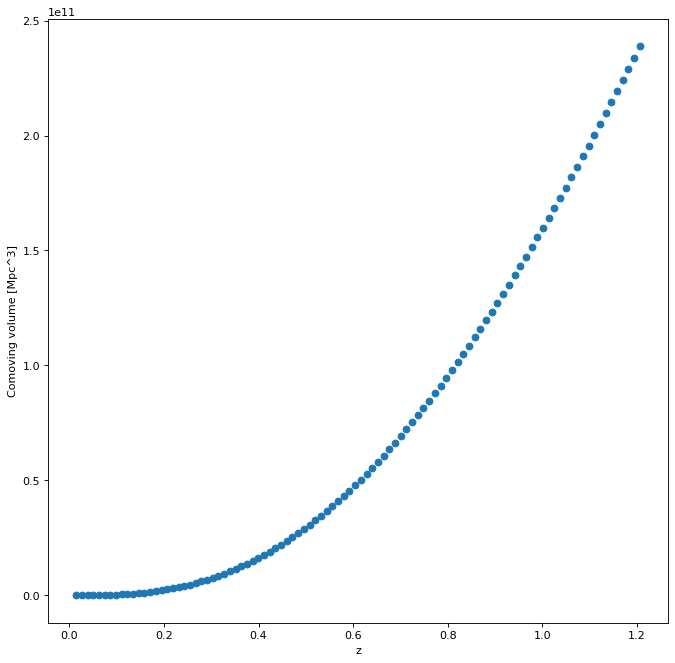

In [11]:
#Calculate Comoving Volume

comoving_volume = WMAP9.comoving_volume(bins_z)  #Give Volume in Mpc^3
comoving_volume_unbinned = WMAP9.comoving_volume(z)
#print(comoving_volume)
plt.figure(figsize=(10, 10), dpi=80)
plt.scatter(bins_z, comoving_volume)
plt.xlabel('z')
plt.ylabel('Comoving volume [Mpc^3]')

A cell that has all the required TDE rates (in various units)

In [12]:
#TDE rates

tde = data['TDE_rate']
bin_sum_tde = [tde[digitized_z == i].sum() for i in range(0, len(bins_z))]
bin_sum_tde_per_square_degree = np.array(bin_sum_tde)/survey_area
bin_sum_tde_all_sky = bin_sum_tde_per_square_degree*41253
bin_sum_tde_all_sky_cum = np.cumsum(bin_sum_tde_all_sky)
bin_sum_tde_per_vol = bin_sum_tde_all_sky/comoving_volume
bin_sum_tde_per_vol_cum = np.cumsum(bin_sum_tde_per_vol)
#print(comoving_volume)

C:\Users\steve\AppData\Local\Temp\ipykernel_7184\3224843438.py:4: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(bin_means_z, np.log10(np.array(np.cumsum(bin_sum_tde_per_square_degree))))


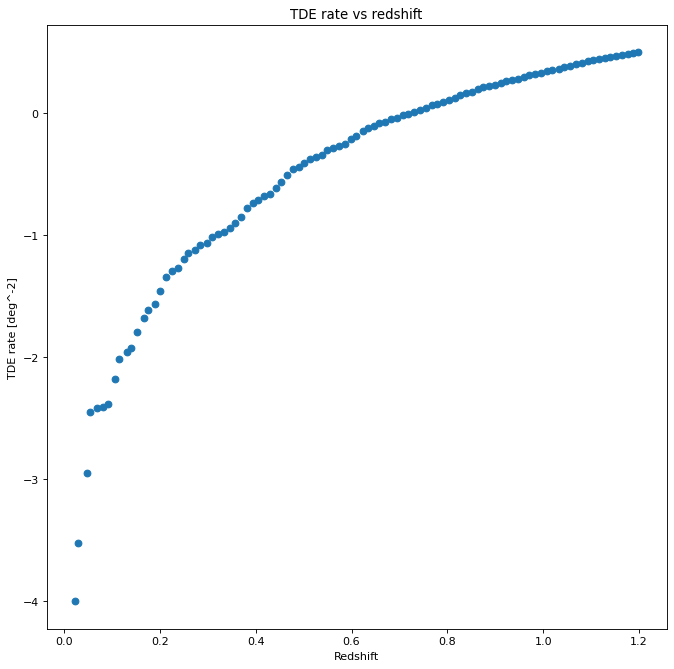

In [13]:
#Cumulative TDE rate per square degree LOG

plt.figure(figsize=(10, 10), dpi=80)
plt.scatter(bin_means_z, np.log10(np.array(np.cumsum(bin_sum_tde_per_square_degree))))
plt.xlabel('Redshift')
plt.ylabel('TDE rate [deg^-2]')
plt.title('TDE rate vs redshift')

plt.show()

C:\Users\steve\AppData\Local\Temp\ipykernel_7184\340102095.py:4: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(bin_means_z, np.log10(np.array(np.cumsum(bin_sum_tde_all_sky/2))))


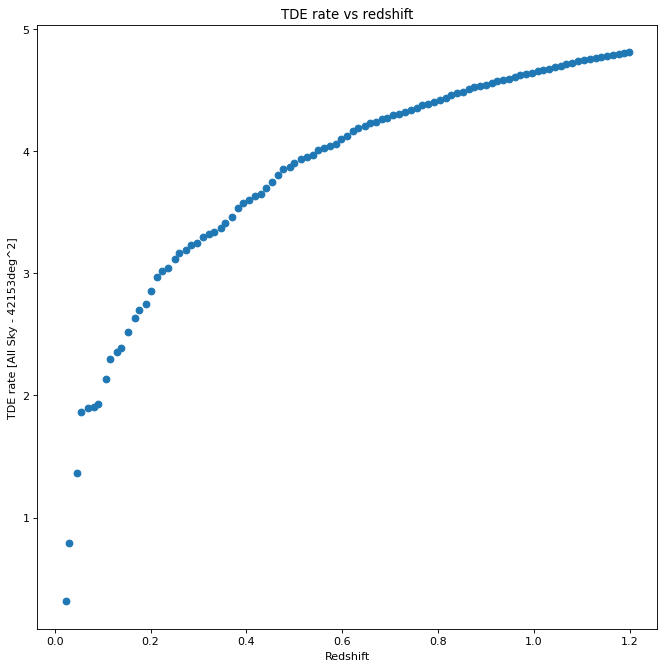

In [14]:
#Cumulative TDE rate all sky - 20,000 deg^2 for LSST LOG

plt.figure(figsize=(10, 10), dpi=80)
plt.scatter(bin_means_z, np.log10(np.array(np.cumsum(bin_sum_tde_all_sky/2))))
plt.xlabel('Redshift')
plt.ylabel('TDE rate [All Sky - 42153deg^2]')
plt.title('TDE rate vs redshift')

plt.show()

In [15]:
#TDE rate all sky cumulutive

# plt.figure(figsize=(10, 10), dpi=80)
# plt.scatter(bin_means_z, np.array(bin_sum_tde_all_sky_cum))
# plt.xlabel('Redshift')
# plt.ylabel('Cumulative TDE rate [All Sky - 42153deg^2]')
# plt.title('Cumulative TDE rate vs redshift')

# plt.show()

The visually important graph for TDE rates which are off by a factor of 10

In [16]:
#TDE rate all sky cumulutive as a LOG graph

# plt.figure(figsize=(10, 10), dpi=80)
# plt.scatter(bin_means_z, np.log10(np.array(bin_sum_tde_all_sky_cum)))
# plt.xlabel('Redshift')
# plt.ylabel('LOG Cumulative TDE rate [All Sky - 42153deg^2]')
# plt.title('LOG Cumulative TDE rate vs redshift')

# #plt.show()

In [17]:
#TDE rate per Mpc^3

# plt.figure(figsize=(10, 10), dpi=80)
# plt.scatter(bin_means_z, np.array(bin_sum_tde_per_vol))
# plt.xlabel('Redshift')
# plt.ylabel('TDE rate [Mpc-3]')
# plt.title('TDE rate vs redshift')

# plt.show()

In [18]:
#TDE rate per Mpc^3 as a LOG graph

# bin_sum_tde_per_vol_cum_log = bin_sum_tde_per_vol_cum.value
# plt.figure(figsize=(10, 10), dpi=80)
# plt.scatter(bin_means_z, np.log10(bin_sum_tde_per_vol.value))
# plt.xlabel('Redshift')
# plt.ylabel('LOG TDE rate [Mpc-3]')
# plt.title('LOG TDE rate vs redshift')

# plt.show()

In [19]:
#TDE rate per Mpc^3 cumulative

# plt.figure(figsize=(10, 10), dpi=80)
# plt.scatter(bin_means_z, np.array(bin_sum_tde_per_vol_cum))
# plt.xlabel('Redshift')
# plt.ylabel('Cumulative TDE rate [Mpc-3]')
# plt.title('Cumulative TDE rate vs redshift')

# plt.show()

C:\Users\steve\AppData\Local\Temp\ipykernel_7184\3312074129.py:4: RuntimeWarning: divide by zero encountered in log
  bin_sum_tde_per_vol_cum_log = [np.log(x) for x in bin_sum_tde_per_vol_cum.value]
C:\Users\steve\AppData\Local\Temp\ipykernel_7184\3312074129.py:6: RuntimeWarning: divide by zero encountered in log10
  bin_sum_tde_per_vol_cum_log = np.log10(bin_sum_tde_per_vol_cum.value)


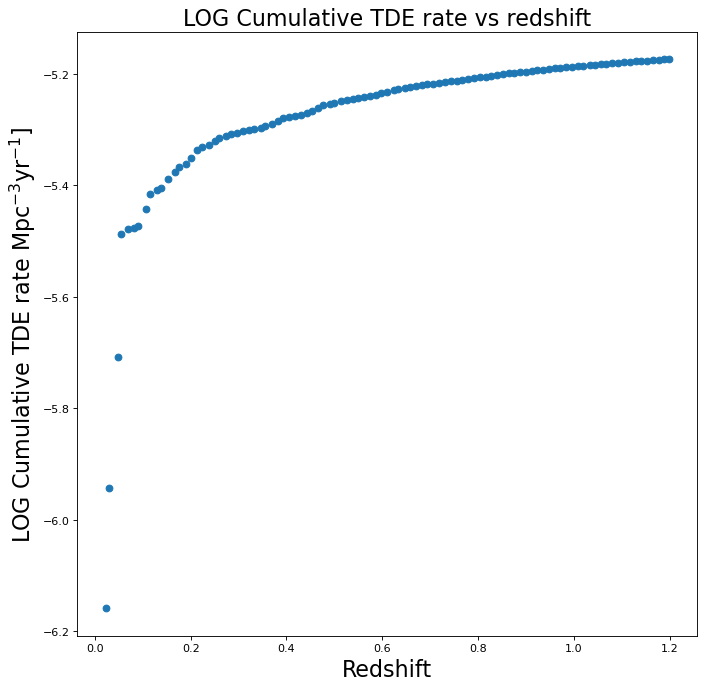

In [20]:
#TDE rate per Mpc^3 cumulative as a LOG graph
fontsize = 20
#print(bin_sum_tde_per_vol_cum)
bin_sum_tde_per_vol_cum_log = [np.log(x) for x in bin_sum_tde_per_vol_cum.value]
bin_means_z_log = [np.log(x) for x in bin_means_z]
bin_sum_tde_per_vol_cum_log = np.log10(bin_sum_tde_per_vol_cum.value)
plt.figure(figsize=(10, 10), dpi=80)
plt.scatter(bin_means_z, bin_sum_tde_per_vol_cum_log)
plt.xlabel('Redshift', fontdict={'fontsize': fontsize})
plt.ylabel('LOG Cumulative TDE rate Mpc$^{-3}$yr$^{-1}$]', fontdict={'fontsize': fontsize})
plt.title('LOG Cumulative TDE rate vs redshift',fontdict={'fontsize': fontsize})

plt.show()

In [21]:
Luminosity = data['Keck_DEIMOS_DEEP_B_Absolute']
# print(Luminosity)

In [22]:
bin_Lum = [Luminosity[digitized_z == i].sum() for i in range(0, len(bins_z))]
# print(bin_Lum)
# plt.figure(figsize=(10, 10), dpi=80)
# plt.scatter(bin_means_z, np.array(bin_Lum))
# plt.xlabel('Redshift')
# plt.ylabel('Luminosity')
# plt.title('Luminosity vs redshift')

The code to create SN rates assuming const rate per sm

In [23]:
#Supernova rates assuming const per stellar mass
h = 0.7
sm = data['supernovae_rate_assuming_const_rate_per_stellar_mass'] 
bin_sum_sm = [sm[digitized_z == i].sum() for i in range(0, len(bins_z))]
bin_sum_sm_per_square_degree = np.array(bin_sum_sm)/survey_area
bin_sum_sm_all_sky = bin_sum_sm_per_square_degree*41253
bin_sum_sm_all_sky_cum = np.cumsum(bin_sum_sm_all_sky)
bin_sum_sm_per_vol = bin_sum_sm_all_sky/comoving_volume
bin_sum_sm_per_vol_cum = np.cumsum(bin_sum_sm_per_vol)

In [24]:
#Supernova rate assuming constant rate per stellar mass per square degree

# plt.figure(figsize=(10, 10), dpi=80)
# plt.scatter(bin_means_z, np.array(bin_sum_sm_per_square_degree))
# plt.xlabel('Redshift')
# plt.ylabel('Supernova rate [deg^-2]')
# plt.title('Supernova rate assuming const rate per stellar mass vs redshift')

#plt.show()

In [25]:
#Supernova rate assuming const rate per stellar mass all sky

# plt.figure(figsize=(10, 10), dpi=80)
# plt.scatter(bin_means_z, np.array(bin_sum_sm_all_sky))
# plt.xlabel('Redshift')
# plt.ylabel('Supernova rate [All sky - 41253deg2]')
# plt.title('Supernova rate assuming const rate per stellar mass vs redshift')

#plt.show()

In [26]:
#Supernova rate assuming const rate per stellar mass all sky as a LOG GRAPH

# plt.figure(figsize=(10, 10), dpi=80)
# plt.scatter(bin_means_z,np.log10(np.array(bin_sum_sm_all_sky)))
# plt.xlabel('Redshift')
# plt.ylabel('Supernova rate [All sky - 41253deg2]')
# plt.title('Supernova rate assuming const rate per stellar mass vs redshift')

#plt.show()

In [27]:
#Cumulutive Supernova rate assuming const rate per stellar mass all sky

# plt.figure(figsize=(10, 10), dpi=80)
# plt.scatter(bin_means_z, (np.array(bin_sum_sm_all_sky_cum)))
# plt.xlabel('Redshift')
# plt.ylabel('Cumulative Supernova rate [All sky - 41253deg2]')
# plt.title('Cumulative Supernova assuming const rate rate per stellar mass vs redshift')

#plt.show()

In [28]:
#Cumulutive Supernova rate assuming const rate per stellar mass all sky as a LOG GRAPPH
# bin_sum_sm_all_sky_cum_log = [np.log10(x) for x in bin_sum_sm_all_sky_cum]
# plt.figure(figsize=(10, 10), dpi=80)
# plt.scatter(bin_means_z, bin_sum_sm_all_sky_cum_log)
# plt.xlabel('Redshift')
# plt.ylabel('Cumulative Supernova rate [All sky - 41253deg2]')
# plt.title('Cumulative Supernova rate assuming const rate per stellar mass vs redshift')

#plt.show()

In [29]:
#Supernova rate assuming const rate per stellar mass per Mpc^3

# plt.figure(figsize=(10, 10), dpi=80)
# plt.scatter(bin_means_z, np.array(bin_sum_sm_per_vol))
# plt.xlabel('Redshift')
# plt.ylabel('Supernova rate [Mpc^-3]')
# plt.title('Supernova rate assuming const rate per stellar mass vs redshift')

plt.show()

C:\Users\steve\AppData\Local\Temp\ipykernel_7184\4013465423.py:4: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(bin_means_z, np.log10(np.array(bin_sum_sm_per_vol_cum)))


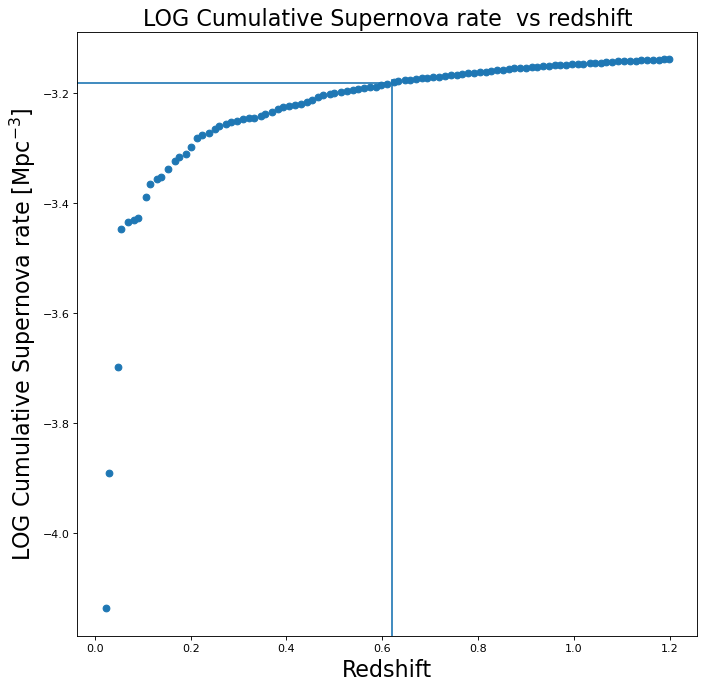

C:\Users\steve\AppData\Local\Temp\ipykernel_7184\4013465423.py:11: RuntimeWarning: divide by zero encountered in log10
  np.interp(0.62, bin_means_z,  np.log10(np.array(bin_sum_sm_per_vol_cum)))


-3.1809746320906425

In [30]:
#Cumulutive Supernova rate assuming const rate per stellar mass per Mpc^3
fontsize = 20
plt.figure(figsize=(10, 10), dpi=80)
plt.scatter(bin_means_z, np.log10(np.array(bin_sum_sm_per_vol_cum)))
plt.xlabel('Redshift', fontdict={'fontsize': fontsize})
plt.ylabel('LOG Cumulative Supernova rate [Mpc$^{-3}$]', fontdict={'fontsize': fontsize})
plt.title('LOG Cumulative Supernova rate  vs redshift', fontdict={'fontsize': fontsize})
plt.axvline(x =0.62, ymin = 0, ymax = 0.92)
plt.axhline(y = -3.1809746320906425, xmin = 0.0, xmax = 0.5)
plt.show()
np.interp(0.62, bin_means_z,  np.log10(np.array(bin_sum_sm_per_vol_cum)))


Code to create SN rates assuming const rate per SFR

In [31]:
#Supernova rates assuming const rate per star formation rate

sfr = data['supernovae_rate_assuming_const_rate_per_star_formation_rate']
bin_sum_sfr = [sfr[digitized_z == i].sum() for i in range(0, len(bins_z))]
bin_sum_sfr_per_square_degree = np.array(bin_sum_sfr)/survey_area
bin_sum_sfr_all_sky = bin_sum_sfr_per_square_degree*41253
bin_sum_sfr_all_sky_cum = np.cumsum(bin_sum_sfr_all_sky)
bin_sum_sfr_per_vol = bin_sum_sfr_all_sky/comoving_volume
bin_sum_sfr_per_vol_cum = np.cumsum(bin_sum_sfr_per_vol)

In [32]:
#Supernova rates assuming const rate per star formation rate per square degree

# plt.figure(figsize=(10, 10), dpi=80)
# plt.scatter(bin_means_z, np.array(bin_sum_sfr_per_square_degree))
# plt.xlabel('Redshift')
# plt.ylabel('Supernova rate [deg^-2]')
# plt.title('Supernova rate assuming const rate per star formation rate vs redshift')

#plt.show()

In [33]:
#Supernova rates assuming const rate per star formation rate all sky

# plt.figure(figsize=(10, 10), dpi=80)
# plt.scatter(bin_means_z, np.array(bin_sum_sfr_all_sky))
# plt.xlabel('Redshift')
# plt.ylabel('Supernova rate [All sky - 41253deg2]')
# plt.title('Supernova rate assuming const rate per star formation rate vs redshift')

#plt.show()

In [34]:
#Cumulutive Supernova rates assuming const rate per star formation rate all sky

# plt.figure(figsize=(10, 10), dpi=80)
# plt.scatter(bin_means_z, np.array(bin_sum_sfr_all_sky_cum))
# plt.xlabel('Redshift')
# plt.ylabel('Cumulative Supernova rate [All sky - 41253deg2]')
# plt.title('Cumulative Supernova assuming const rate rate per star formation rate vs redshift')

#plt.show()

In [35]:
#Cumulutive Supernova rates assuming const rate per star formation rate all sky as a LOG GRAPH

# plt.figure(figsize=(10, 10), dpi=80)
# plt.scatter(bin_means_z, np.log10(np.array(bin_sum_sfr_all_sky_cum)))
# plt.xlabel('Redshift')
# plt.ylabel('LOG Cumulative Supernova rate [All sky - 41253deg2]')
# plt.title('LOG Cumulative Supernova rate assuming const rate per star formation rate vs redshift')

#plt.show()

In [36]:
#Supernova rates assuming const rate per star formation rate per Mpc^3

# plt.figure(figsize=(10, 10), dpi=80)
# plt.scatter(bin_means_z, np.log10(np.array(bin_sum_sfr_per_vol)))
# plt.xlabel('Redshift')
# plt.ylabel('Supernova rate [Mpc^-3]')
# plt.title('Supernova rate assuming const rate per star formation rate vs redshift')

# plt.show()

In [37]:
#Cumulutive Supernova rates assuming const rate per star formation rate per Mpc^3

# plt.figure(figsize=(10, 10), dpi=80)
# plt.scatter(bin_means_z, np.array(bin_sum_sfr_per_vol_cum))
# plt.xlabel('Redshift')
# plt.ylabel('Cumulative Supernova rate [Mpc^-3]')
# plt.title('Cumulative Supernova rate assuming const rate per star formation rate vs redshift')

plt.show()

C:\Users\steve\AppData\Local\Temp\ipykernel_7184\4231373826.py:5: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(bin_means_z, np.log10(np.array(bin_sum_sfr_per_vol_cum)))


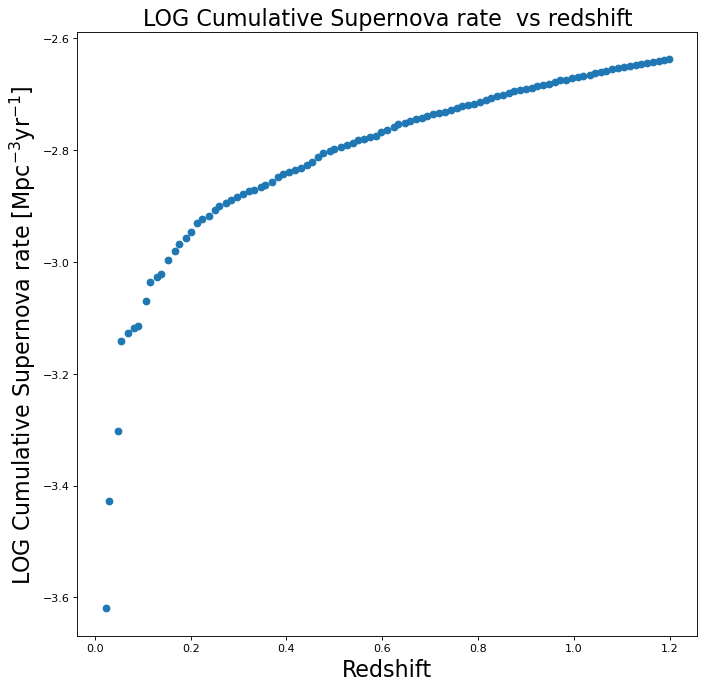

In [38]:
#Cumulutive Supernova rates assuming const rate per star formation rate per Mpc^3 as a LOG GRAPH

fontsize = 20
plt.figure(figsize=(10, 10), dpi=80)
plt.scatter(bin_means_z, np.log10(np.array(bin_sum_sfr_per_vol_cum)))
plt.xlabel('Redshift', fontdict={'fontsize': fontsize})
plt.ylabel('LOG Cumulative Supernova rate [Mpc$^{-3}$yr$^{-1}$]', fontdict={'fontsize': fontsize})
plt.title('LOG Cumulative Supernova rate  vs redshift', fontdict={'fontsize': fontsize})

plt.show()

Code to create Stellar Mass Function plots for Millenium at Z=0, Z=0.1, and Z=1

In [39]:
h = 0.73

This first graph needs to be corrected for feedback etc

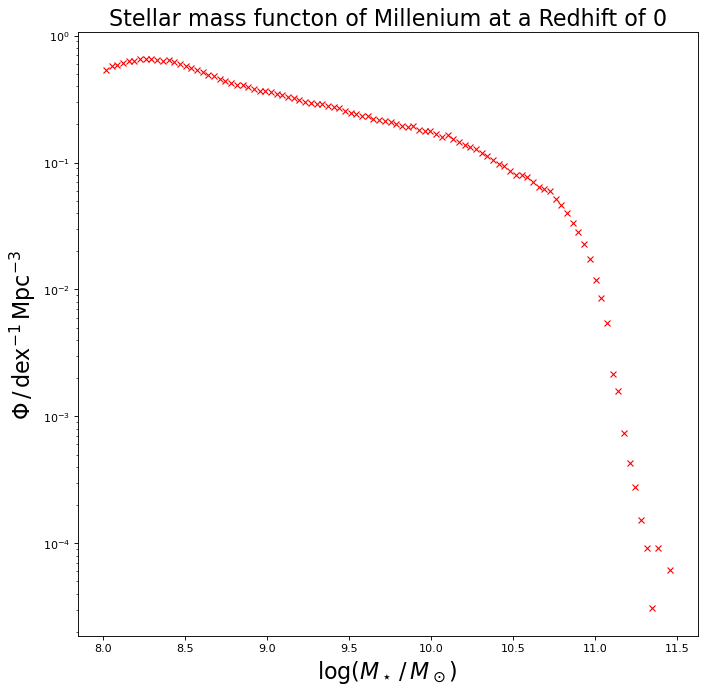

In [40]:
import numpy as np
import matplotlib.pyplot as plt
fontsize = 20
Co_Vol_at_z1 = np.interp(0.000000000001,bins_z,comoving_volume)

M     = data_0['Total_Stellar_Mass']*10**10         #Read stellar masses in Msun
#total_sm = [M[digitized_z == i].sum() for i in range(1, len(bins_z))]
#sm = M[1:30]
#print(sm)
#print(total_sm)
logM  = np.log10(M)                     #Take logarithm
nbins = 100                              #Number of bins to divide data into
V     = Co_Vol_at_z1                           #Survey volume in Mpc3
Phi,edg = np.histogram(logM,bins=nbins) #Unnormalized histogram and bin edges
dM    = edg[1] - edg[0]  #Bin size
Max   = edg[0:-1] + dM/2.               #Mass axis
Phi   = Phi / V / dM                    #Normalize to volume and bin size
plt.figure(figsize=(10, 10), dpi=80)
plt.clf()
plt.yscale('log')
plt.xlabel(r'$\log(M_\star\,/\,M_\odot)$', fontdict={'fontsize': fontsize})
plt.ylabel(r'$\Phi\,/\,\mathrm{dex}^{-1}\,\mathrm{Mpc}^{-3}$', fontdict={'fontsize': fontsize})
plt.title(r'Stellar mass functon of Millenium at a Redhift of 0', fontdict={'fontsize': fontsize})
plt.plot(Max,Phi,'rx')

In [41]:
# import numpy as np
# import matplotlib.pyplot as plt

# Co_Vol_at_z2 = np.interp(0.0000000000000001,bins_z,comoving_volume)
# M= data_0['Total_Stellar_Mass']*10**10   #Read stellar masses in Msun
# logM  = np.log10(M)                     #Take logarithm
# nbins = 100                              #Number of bins to divide data into
# V     = Co_Vol_at_z2                            #Survey volume in Mpc3
# Phi,edg = np.histogram(logM,bins=nbins) #Unnormalized histogram and bin edges
# dM    = edg[1] - edg[0]                 #Bin size
# Max   = edg[0:-1] + dM/2.               #Mass axis
# Phi   = Phi / V / dM                    #Normalize to volume and bin size
# plt.figure(figsize=(10, 10), dpi=80)
# plt.clf()
# plt.yscale('log')
# plt.xlabel(r'$\log(M_\star\,/\,M_\odot)$')
# plt.ylabel(r'$\Phi\,/\,\mathrm{dex}^{-1}\,\mathrm{Mpc}^{-3}$')
# plt.plot(Max,Phi,ls='dashed')
# print(edg[1])

In [42]:
# Co_Vol_at_z3 = np.interp(1,bins_z,comoving_volume)

# M     = data_0['Total_Stellar_Mass']*10**10         #Read stellar masses in Msun
# logM  = np.log10(M)                     #Take logarithm
# nbins = 100                              #Number of bins to divide data into
# V     = Co_Vol_at_z3                           #Survey volume in Mpc3
# Phi,edg = np.histogram(logM,bins=nbins) #Unnormalized histogram and bin edges
# dM    = edg[1] - edg[0]                 #Bin size
# Max   = edg[0:-1] + dM/2.               #Mass axis
# Phi   = Phi / V / dM                    #Normalize to volume and bin size
# plt.figure(figsize=(10, 10), dpi=80)
# plt.clf()
# plt.yscale('log')
# plt.xlabel(r'$\log(M_\star\,/\,M_\odot)$')
# plt.ylabel(r'$\Phi\,/\,\mathrm{dex}^{-1}\,\mathrm{Mpc}^{-3}$')
# plt.plot(Max,Phi,ls='dashed')

Attemp to plot of SFR density against Redshift

In [43]:
TOTAL_SFR_RATE = data_0['Total_Star_Formation_Rate']
bin_sum_totalsfr = [TOTAL_SFR_RATE[digitized_z == i].sum() for i in range(0, len(bins_z))]
bin_sum_totalsfr_per_square_degree = np.array(bin_sum_sfr)/survey_area
bin_sum_totalsfr_all_sky = bin_sum_totalsfr_per_square_degree*41253
bin_sum_totalsfr_all_sky_cum = np.cumsum(bin_sum_totalsfr_all_sky)
bin_sum_totalsfr_per_vol = bin_sum_totalsfr_all_sky/comoving_volume
bin_sum_totalsfr_per_vol_cum = np.cumsum(bin_sum_totalsfr_per_vol)

In [44]:
#print(bin_sum_totalsfr_per_vol)

This plot's vertical axis should be centred around -2 - our graph is shifted vertically lower - why?

In [45]:
#Plotting SFR against Z
# plt.figure(figsize=(10, 10), dpi=80)
# plt.scatter(bin_means_z, np.log10(bin_sum_totalsfr_per_vol_cum.value))
# plt.xlabel('')
# plt.ylabel('')
# plt.title('')

# plt.show()

Improving our TDE Rate Equation 

In the following cell i will use Van Velzen (2018) method of summing the 1/Vmax in bins of luminosity in order to find a luminosity function of TDE's.
We have to use the flux limit of the survey.

In [46]:
lum = data_0['Keck_DEIMOS_DEEP_B_Apparent']
print(Luminosity)

160095   -14.7625
217670   -16.8128
217671   -15.7348
217668   -16.3496
217674   -20.9465
           ...   
482401   -17.2887
382182   -21.6527
577975   -17.2813
578036   -17.3050
578008   -18.9706
Name: Keck_DEIMOS_DEEP_B_Absolute, Length: 827976, dtype: float64


In [47]:
# plt.figure(figsize=(10, 10), dpi=80)
# plt.scatter(z, lum)
# plt.xlabel('')
# plt.ylabel('')
# plt.title('')
# plt.xlim([0, 0.1])
# plt.ylim([15, 25])

In [48]:
bins_lum = np.linspace(np.min(lum), np.max(lum), no_of_bins)
binsize = (np.max(lum) - np.min(lum))/no_of_bins
digitized_lum = np.digitize(lum, bins_lum) #creates mask for each bin
bin_means_lum = [lum[digitized_lum == i].mean() for i in range(0, len(bins_lum))]

In [49]:
print(len(bin_means_lum)) #want len of Vmax to match this so 

100


In [50]:
A = RA * DEC
zmax = 0.1
VZmax = np.interp(1, bin_means_z, comoving_volume)
Tau = 60*60 ## What is the correct value for survey time?



Vmax = VZmax * A * Tau
print(Vmax)

160095    8.492332e+14
217670    2.886854e+13
217671    1.949476e+14
217668    3.545119e+14
217674    2.485752e+14
              ...     
482401    1.152620e+15
382182    1.735774e+14
577975    1.457938e+15
578036    1.456559e+15
578008    1.438110e+15
Length: 827976, dtype: float64


In [51]:
bin_sum_Vmax = [lum[digitized_lum == i].sum() for i in range(0, len(bins_lum))]
#print(bin_sum_Vmax)
yy = bin_sum_Vmax[1:]
#print(xx)
yyy = bin_sum_Vmax[1:30]
#print(xxx)
xxx = bin_means_lum[1:30]
#print(xxx)
Lum_bin = [i*4*10**26 for i in xxx]
# bin_sum_Vmax.sort()
#print(yyy)
# for num in xxx:
#     y = 1/num
#     print(y)

In [52]:
# plt.figure(figsize=(10, 10), dpi=80)
# plt.scatter(Lum_bin, yyy)
# plt.xlabel('Lum')
# plt.ylabel('1/Vmax')
# plt.title('')

# plt.show()

Following graph is 1/Vmax against bins of Lum

In [53]:
y = [1 / y for y in yyy]

In [54]:
# plt.figure(figsize=(10, 10), dpi=80)
# plt.scatter(Lum_bin, y)
# plt.xlabel('Lum')
# plt.ylabel('1/Vmax')
# plt.title('')

# plt.show()

In [55]:
#Summed all of the Lums

# bin_sum_Vmax = [lum[digitized_lum == i].sum() for i in range(0, len(bins_lum))]
# #print(bin_sum_Vmax)
# bin_sum_Vmax.sort()
# plt.figure(figsize=(10, 10), dpi=80)
# plt.scatter(bin_means_lum, bin_sum_Vmax)
# plt.xlabel('')
# plt.ylabel('')
# plt.title('')

# plt.show()

From here, we want to plot Van Velzen(2018) method and find the well fitted power law/estimation which should give us our corrected value of 10^-4 instead of our modelled value of 10^-5

In [56]:
# # l = Lum **1*10**24
# for i in Lum:
#     x1 = i*1*10**24
#     print(x1)
# l = [ i*1*10**24 for i in Lum]
# print(l)

In [57]:
#For help y = [1 / y for y in yyy]
#print(l)
Tde = [2*10**-7*(p/1*10**37)**(-1.5) for p in Lum_bin]
#tde = np.array(Tde)
#print(tde)
#print(Tde)
denominator = [np.log10(x) for x in Lum_bin]  
#ll = np.array(l)
#lll = l*1*10**26 ##### Want to divide Tde by denominator but cant because need to iterator through denminator to log every value inside 
#print(lll)
#print(denominator)
#d = np.array(denominator)
#print(np.log10(l[0])) # matches first log value so works 
# for j in denominator:
#     print(j)
# for j in Tde:
#     print(j)
n = [i / np.log10(j) for i, j in zip(Tde, denominator)]
print(n)
#type(denominator)
#type(Tde)
#x = [i/denominator for i in Tde]
    #print(x)
#     Lum_bin = [lum[digitized_lum == i].sum() for i in range(0, len(bins_z))]
#     print(Lum_bin)

[1.1872012077729327e-104, 1.0144112138380703e-104, 9.325487309649668e-105, 8.536846142171111e-105, 7.873838931295802e-105, 7.306958765517573e-105, 6.793665959022192e-105, 6.3371000929258805e-105, 5.925981381572787e-105, 5.5609331695015315e-105, 5.234018083890932e-105, 4.9431471194790515e-105, 4.67687882471073e-105, 4.432311600763419e-105, 4.207119615237172e-105, 4.003009042867792e-105, 3.8150285071738566e-105, 3.636072240922594e-105, 3.4692173336229265e-105, 3.3203901400703645e-105, 3.186616012577225e-105, 3.0691115458128138e-105, 2.936548752278416e-105, 2.814244863809685e-105, 2.710794296800411e-105, 2.6056315338347423e-105, 2.5163235257784146e-105, 2.444524394864152e-105, 2.3371204162068374e-105]


Attempt to plot their log fit function onto my graph to see if they match

In [58]:
# plt.figure(figsize=(10, 10), dpi=80)
# n_bin = [lum[digitized_lum == i].sum() for i in range(0, len(bins_lum))]
# #print(x)
# print(tde)
# #plt.scatter(Lum_bin, y)
# plt.scatter(Lum_bin, n)
# plt.xlabel('Lum bin')
# plt.ylabel('TDE')
# plt.title('')

# plt.show()